In [47]:
import cv2
import numpy as np
import pickle
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt

In [48]:
# Load the trained LDA and KNN models
with open('lda_model.pkl', 'rb') as lda_file:
    lda = pickle.load(lda_file)

with open('svm_model.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

In [49]:
# Function to find and extract components from an image
def extract_components(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, binary = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Morphological operations to improve segmentation
    kernel = np.ones((45, 45), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    components = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w > 70 and h > 70:  # Filter out small components
            component = image[y:y+h, x:x+w]
            components.append(component)
    return components, binary, contours


In [50]:
# Function to preprocess an image component
def preprocess_component(component, size=(50, 50)):
    resized = cv2.resize(component, size)
    return resized

In [57]:
# Load the test image
test_image_path = 'C:/Users/siang/MMU/Pattern Recognition/project/dataset/counting/IMG_3080.jpg'
test_image = cv2.imread(test_image_path)

In [58]:
# Visualize the segmentation results
def visualize_segmentation(image, binary, contours):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(binary, cmap='gray')
    plt.title('Binary Image')
    plt.axis('off')

    image_with_contours = image.copy()
    cv2.drawContours(image_with_contours, contours, -1, (0, 255, 0), 2)
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
    plt.title('Detected Contours')
    plt.axis('off')
    plt.show()

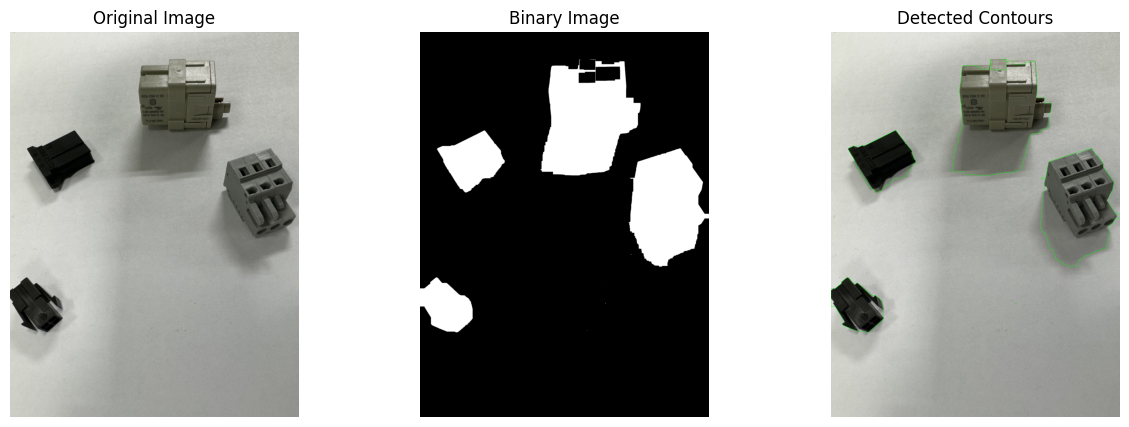

Label Counts: {2: 1, 3: 3}
Total Number of Components: 4


In [59]:
# Extract components from the test image
components, binary, contours = extract_components(test_image)

visualize_segmentation(test_image, binary, contours)
# Preprocess and transform each component
component_features = []
for component in components:
    preprocessed = preprocess_component(component)
    flat = preprocessed.flatten().reshape(1, -1) / 255.0  # Normalize and flatten
    lda_transformed = lda.transform(flat)
    component_features.append(lda_transformed)

# Convert to numpy array
component_features = np.array(component_features).reshape(len(components), -1)

# Predict labels for each component
predictions = model.predict(component_features)

# Count the occurrences of each label
unique, counts = np.unique(predictions, return_counts=True)
label_counts = dict(zip(unique, counts))

print("Label Counts:", label_counts)
print("Total Number of Components:", len(components))